In [ ]:
# Ejecutar para limpiar espacio en Colab
!kill -9 -1

# Proyecto Final (Image + Text + Multi-Modal (Image + Text))

### Curso Deep Learning y Redes Neuronales - MIIA4406_01

#### Universidad de los Andes

Integrantes:

|Nombre|Codigo|
|---------------------|---------------------|
|Saby Espinel|*201215868*|
|Diego Salazar|*201628925*| <br>
<br>

*********************************************************************************************

## Verificacion de uso de 'GPU'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

# Librerias y Funciones

In [ ]:
## Librerias para cargar en Jupyter y CoLab ##

# Librerias Machine Learning
!pip install tqdm
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm

# Text processing
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split

# Text 
from keras.utils import np_utils, plot_model
from keras.layers import Embedding, LSTM, Reshape, concatenate
from keras.optimizers import RMSprop
from keras.callbacks import History
#from pydot import pydot

## Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
from keras.layers import Conv2D, RepeatVector, TimeDistributed, Activation, GlobalMaxPooling2D, MaxPooling2D, Flatten, Dropout, Dense, Input, BatchNormalization#, merge, Merge
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Model, Sequential

%matplotlib inline

In [ ]:
## Para cargar en CoLab ##
!pip install -U -q PyDrive
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
## Para cargar en CoLab ##
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Funciones

In [ ]:
# extract features from each photo in the directory
def extract_features(directory):
    from keras.applications.vgg16 import preprocess_input
    # load the model
    in_layer = Input(shape=(224, 224, 3))
    model = VGG16(include_top=False, input_tensor=in_layer)
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in tqdm(os.listdir(directory)):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features

# Definicion de funcion para preprocesar el texto ->
# (dataTraining['post'] and dataTesting['post'])
def preProssText(df, commonWord, numberCommonWords, rareWord, numberRareWords, spellCorrect):
    # Remove punctutation
    df['plot'] = df['plot'].str.replace('[^\w\s]','')
    
    # Lower case
    df['plot'] = df['plot'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    # Remove Common words
    if commonWord == True:
        freq = pd.Series(' '.join(df['plot']).split()).value_counts()[:numberCommonWords]
        df['plot'] = df['plot'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    
    # Remove Rare words
    if rareWord == True:
        freq = pd.Series(' '.join(df['plot']).split()).value_counts()[-numberRareWords:]
        df['plot'] = df['plot'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    
    # Spelling correction -> Tener cuidado puede cambiar los valores. Ej: "ur" por "or" en vez de "your"
    if spellCorrect == True:
        from textblob import TextBlob
        df['plot'] = df['plot'].apply(lambda x: str(TextBlob(x).correct()))
    
    return df

# define a function that accepts text and returns a list of lemmas
import nltk
nltk.download('wordnet')

def split_into_lemmas(text):
    from nltk.stem import WordNetLemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

# define a function that accepts text and returns a list of stem
def split_into_stem(text):
    stemmer = SnowballStemmer('english')
    text = text.lower()
    words = text.split()
    return [stemmer.stem(word) for word in words]

*********************************************************************************************

## Load files (txt + img) in CoLab

In [ ]:
# Verificacion de contenido de carpetas en el Drive con su respectivo ID
file_list = drive.ListFile({'q': "'1gX_xAhoYwIwmOVRd33lAuf4pCM3cChB6' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: ML_Final.ipynb, id: 10A5sIsjOxbI2D2fGGr4DIqCtzclGeOUG
title: pred_genres_img_RF.csv, id: 1l734WEkdZIeCUxGqJw_i0czo1bfm12IR
title: CombinadoFinal.ipynb, id: 1m2dderm11SQk0T3nkZ2kZXpHJQlaj0lB
title: colabcombinado, id: 1Lo3bVt7cHIoOHVPjrbILOW-8ocWGjH0w
title: ImageColab.ipynb, id: 1QI4l_c2wejdKDavNVdmMz6DSP0es2Jf2
title: Resultados.xlsx, id: 1Lykn5EEY4RTyTesTN6f5d0LDm1AqIuGv
title: 0-ColabCombinado, id: 1WhxbiFAE5vCZyu8xLcxpHNKmdTxrS52O
title: 0-CombinacionesText, id: 1Lk9Ek6fOIAV6v9ysYe8U8beBpvFEtbPfqVb6tyd-_I4
title: TextColab.ipynb, id: 1sEAr0qGqVwDkmZJjw4o1UC3owfqykJma
title: Combinado.ipynb, id: 1rGKRTd8TTYKGkxvf3_o65MC5hwEK2B6q
title: Final Project.pptx, id: 17-MkUf4ltoGnoNHS8XhuI2PzG0Igd9YF
title: Resultados, id: 1mUYucRY_uccBGTQUjG08Rg_rtRsj1h9ziLEXgjAeZSA
title: ProcText (1).ipynb, id: 1k6E6N6jG6PCCwXzgoEKCskST6_HwCYAO
title: ProcText.ipynb, id: 1d6n-hMm0W-Y9nXuUmGbfEACnmFmcUA2Z
title: features.pkl, id: 1gT_mDY7-1O9nwvWjFQj2qaVNhfl0TPFw
title: Final Project, id: 1PIyDb9Q8

In [ ]:
trainDrive = drive.CreateFile({'id': '1SKNGe6FFghASG38LjtUaoTrmozUibRCZ'})
trainDrive.GetContentFile('dataTraining.csv')
dataTraining=pd.read_csv("dataTraining.csv", index_col=0)

testDrive = drive.CreateFile({'id': '1JWWmvheWnofZl2zqY-7Gu2rJprceYB80'})
testDrive.GetContentFile('dataTesting.csv')
dataTesting=pd.read_csv("dataTesting.csv", index_col=0)

In [ ]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [ ]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


### Read images

In [ ]:
file_id = '1mcEsaLxakpcQqYZl1pe_qtIEh4FXj0Wx'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])

In [ ]:
# Descomprimir archivo
!unzip -o images_resize_gray.zip

In [ ]:
path='images_resize_gray/'

In [ ]:
image = io.imread(os.path.join(path, str(dataTraining.index[0]) + '_resize_gray.jpeg'))

In [ ]:
image

array([[ 3,  3,  3, ..., 57, 55, 51],
       [ 3,  3,  3, ..., 99, 98, 95],
       [ 3,  3,  3, ..., 97, 96, 94],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

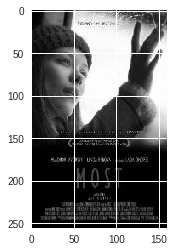

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

In [ ]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join(path, str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████| 7895/7895 [00:05<00:00, 1533.98it/s]


In [ ]:
images_training = np.stack(images_training)

images_training.shape, dataTraining.shape[0]

((7895, 40960), 7895)

In [ ]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████| 3383/3383 [00:01<00:00, 1724.90it/s]


In [ ]:
images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

((3383, 40960), 3383)

In [ ]:
pca = PCA(n_components=32)
images_training_pca = pca.fit_transform(images_training)

In [ ]:
images_testing_pca = pca.transform(images_testing)

## Load files (txt + img) in Jupyter

In [ ]:
#path = '/Users/sabygalvan/Desktop/FinalDL/'
path ="C:/Users/da.salazarb/Google Drive (dasalazarb@unal.edu.co)/AppliedDeepLearningClass-master/finalProject"
dataTraining = pd.read_csv(os.path.join(path, 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [ ]:
# Funcion para seleccionar una muestra de las imagenes
def sampleData(dataTrain, dataTest, varTrain, varTest):
    ix_train=np.random.choice(dataTrain.shape[0], varTrain)
    ix_test=np.random.choice(dataTest.shape[0], varTest)
    return dataTrain.iloc[ix_train], dataTest.iloc[ix_test], ix_train, ix_test

newDataTraining, newDataTesting, ix_train, ix_test  = sampleData(dataTraining, dataTesting, varTrain=500, varTest=50)

In [ ]:
# Imagenes a color
path ="C:/Users/da.salazarb/Google Drive (dasalazarb@unal.edu.co)/AppliedDeepLearningClass-master/finalProject/images_original"
#path='images/'
# Training
images_training = []
newIndexTrain = []
for i in tqdm(newDataTraining.index):
    #path ="C:/Users/da.salazarb/Google Drive (dasalazarb@unal.edu.co)/AppliedDeepLearningClass-master/finalProject/"
    #images_training.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())
    #images_training.append(io.imread(os.path.join(path, str(i) + '_resize_gray.jpeg')))
    archivoImg = cv2.resize(io.imread(os.path.join(path, str(i) + ".jpeg")), (224, 224))
    if len(archivoImg.shape) == 3:
        images_training.append(archivoImg)
        newIndexTrain.append(i)
images_training = np.stack(images_training)
images_training.astype('float32')
images_training /=255

images_training.shape, dataTraining.shape[0], newDataTraining.shape

In [ ]:
# Imagenes en escala de grises
# Testing
images_testing  = []
newIndexTest = []
for i in tqdm(dataTesting.index):
    #images_testing.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())
    images_testing.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')))
    newIndexTest.append(i)

images_testing = np.stack(images_testing)
images_testing.astype('float32')
images_testing /= 255

images_testing.shape, dataTesting.shape[0]

## Clean text in Jupyter and CoLab

In [ ]:
# Pre-procesamiento de texto
dataTraining = preProssText(dataTraining, commonWord=True, numberCommonWords=10, rareWord=True, numberRareWords=10, spellCorrect=False)
dataTesting = preProssText(dataTesting, commonWord=True, numberCommonWords=10, rareWord=True, numberRareWords=10, spellCorrect=False)

In [ ]:
# Create count vectorizer with ngrams
#dataTraining
vect = CountVectorizer(analyzer=split_into_lemmas, ngram_range=(1, 2), max_features=1000, stop_words='english')
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

#dataTesting
vect = CountVectorizer(analyzer=split_into_lemmas, ngram_range=(1, 2), max_features=1000)
X_dtm_test = vect.fit_transform(dataTraining['plot'])
X_dtm_text.shape

## Crear y_genres

In [ ]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])
y_genres.shape

## Split train and test

In [ ]:
# Particion para texto
X_train_txt, X_test_txt, y_train_genres_txt, y_test_genres_txt = train_test_split(X_Text, y_genres, test_size=0.2, random_state=42)
X_train_txt.shape, X_test_txt.shape, y_train_genres_txt.shape, y_test_genres_txt.shape

In [ ]:
# Particion para imagenes
X_train_img, X_test_img, y_train_genres_img, y_test_genres_img = train_test_split(images_training, y_genres, test_size=0.2, random_state=42)
X_train_img.shape, X_test_img.shape, y_train_genres_img.shape, y_test_genres_img.shape

*********************************************************************************************

# **Machine learning**

Text and image are evaluate separately:

### Support Vector Machine - Text

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc=OneVsRestClassifier(svm.SVC(kernel='linear'))

In [ ]:
svc.fit(X_train_txt, y_train_genres_txt)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [ ]:
y_pred_genres = svc.predict(X_test)

In [ ]:
roc_auc_score(y_test_genres_txt, y_pred_genres_txt, average='macro')

0.64082675457253

In [ ]:
#Toma mucho tiempo
from sklearn.cross_validation import cross_val_score
svc=OneVsRestClassifier(svm.SVC(kernel='linear'))
scores = cross_val_score(svc, X_dtm_text, y_genres_txt, cv=10, scoring='accuracy') #cv is cross validation
print(scores)

In [ ]:
print(scores.mean())

In [ ]:
C_range=list(range(1,10))
acc_score=[]
for c in C_range:
    svc = OneVsRestClassifier(svm.SVC(kernel='linear', C=c))
    svc.fit(X_train_txt, y_train_genres_txt)
    y_pred_genres = svc.predict(X_test_txt)
    scores = roc_auc_score(y_test_genres_txt, y_pred_genres_txt, average='macro')
    acc_score.append(scores)
print(acc_score) 

### Logistic Regression - Text

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr=OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [ ]:
lr.fit(X_train_txt, y_train_genres_txt)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [ ]:
y_pred_genres = lr.predict_proba(X_test_txt)

In [ ]:
roc_auc_score(y_test_genres_txt, y_pred_genres_txt, average='macro')

0.7968778530403938

### Random Forest Classifier - Text

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [ ]:
rf=OneVsRestClassifier(RandomForestClassifier())

In [ ]:
rf.fit(X_train_txt, y_train_genres_txt)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

In [ ]:
y_pred_genres = rf.predict_proba(X_test_txt)

In [ ]:
roc_auc_score(y_test_genres_txt, y_pred_genres_txt, average='macro')

0.6828515840350059

In [ ]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = lr.predict_proba(X_dtm_test)

pd.DataFrame(y_pred_test_genres_txt, index=dataTesting_txt.index, columns=cols).to_csv('pred_genres_text_RF.csv', index_label='ID')

In [ ]:
files.download('pred_genres_img_RF.csv')

### Support Vector Machine - Image

In [ ]:
svc=OneVsRestClassifier(svm.SVC())

In [ ]:
svc.fit(X_train_img, y_train_genres_img)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [ ]:
y_pred_genres = svc.predict(X_test_img)

In [ ]:
roc_auc_score(y_test_genres_img, y_pred_genres_img, average='macro')

0.500710191484001

### Logistic Regression - Image

In [ ]:
lr=OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [ ]:
lr.fit(X_train_img, y_train_genres_img)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [ ]:
y_pred_genres = lr.predict_proba(X_test_img)

In [ ]:
roc_auc_score(y_test_genres_img, y_pred_genres_img, average='macro')

0.6137839464894191

### Random Forest Classifier - Image

In [ ]:
rf=OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))

In [ ]:
rf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=1)

In [ ]:
y_pred_genres = rf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.5871600253921408

Now, we try text and image together using a Logistic Regression:

In [ ]:
from scipy.sparse import csr_matrix
#For training dataset
csr=csr_matrix(X_dtm, dtype=np.int8).toarray()
img=pd.DataFrame(images_training_pca)
text=pd.DataFrame(csr)
txtimg=pd.concat([img, text],  axis=1)
img.shape, text.shape, y_genres.shape

#For Testing dataset
X_dtm_test = vect.transform(dataTesting['plot'])
csr_test=csr_matrix(X_dtm_test, dtype=np.int8).toarray()
img=pd.DataFrame(images_testing_pca)
text=pd.DataFrame(csr_test)
txtimg_test=pd.concat([img, text],  axis=1)
img.shape, text.shape

In [ ]:
### Logistic Regression - Image

In [ ]:
lr=OneVsRestClassifier(LogisticRegression(n_jobs=-1))

In [ ]:
lr.fit(txtimg, y_genres)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect whe

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [ ]:
y_pred_genres = lr.predict_proba(txtimg_test)
y_genres.shape, y_pred_genres.shape

In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = lr.predict_proba(txtimg_test)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

In [ ]:
files.download('pred_genres_img_RF.csv')

### Machine learning with (text + image)

In [ ]:
from scipy.sparse import csr_matrix
csr=csr_matrix(X_dtm, dtype=np.int8).toarray()
img=pd.DataFrame(images_training_pca)
text=pd.DataFrame(csr)
txtimg=pd.concat([img, text],  axis=1)

In [ ]:
csr_test=csr_matrix(X_dtm_text, dtype=np.int8).toarray()
img=pd.DataFrame(images_testing_pca)
text=pd.DataFrame(csr_test)
txtimg_test=pd.concat([img, text],  axis=1)

In [ ]:
txtimg.shape

(2000, 550)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
model = OneVsRestClassifier(AdaBoostClassifier(n_estimators=150, learning_rate=.5), n_jobs=-1)
print(cross_val_score(model, txtimg, y_genres))
model.fit(txtimg, y_genres)

OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=150, random_state=None),
          n_jobs=-1)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
model = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0), n_jobs=-1)
cross_val_score(model, txtimg, y_genres)

array([0.08083832, 0.06906907, 0.06306306])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=7, weights = "uniform", algorithm ="auto"), n_jobs=-1)
cross_val_score(model, txtimg, y_genres)
model.fit(txtimg, y_genres)

OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform'),
          n_jobs=-1)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=7, weights = "uniform", algorithm ="auto"), n_jobs=-1)

param = { 
    "estimator__n_neighbors": [5, 7, 10, 14, 20],
    "estimator__algorithm": ["ball_tree", "kd_tree", "brute", "auto"], 
    "estimator__weights": ["uniform", "distance"], 
}

grillaKNeigh=GridSearchCV(estimator = model, 
param_grid = param, n_jobs=-1,iid=False, cv=5)

In [ ]:
grillaKNeigh.fit(txtimg, y_genres)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform'),
          n_jobs=-1),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'estimator__n_neighbors': [5, 7, 10, 14, 20], 'estimator__algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'], 'estimator__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [ ]:
grillaKNeigh.best_params_

{'estimator__algorithm': 'ball_tree',
 'estimator__n_neighbors': 10,
 'estimator__weights': 'distance'}

In [ ]:
grillaKNeigh.best_score_

0.2245

In [ ]:
grillaKNeigh.best_params_

{'estimator__algorithm': 'ball_tree',
 'estimator__n_neighbors': 10,
 'estimator__weights': 'distance'}

In [ ]:
grillaKNeigh.best_score_

0.2245

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
bagging = OneVsRestClassifier(BaggingClassifier(ExtraTreesClassifier(n_estimators=350, max_depth=85, min_samples_split=5, random_state=0), n_jobs=-1
                            max_samples=0.4, max_features=0.5))
cross_val_score(bagging, txtimg, y_genres)

array([0.07496252, 0.06896552, 0.07807808])

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = OneVsRestClassifier(LogisticRegression())
cross_val_score(lr, images_training_pca, y_genres)

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 16 is present in all training examples.
  str(classes[c]))


array([0.02994012, 0.05105105, 0.01801802])

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
model = OneVsRestClassifier(ExtraTreesClassifier(n_estimators=100, max_depth=50, min_samples_split=5, random_state=0),n_jobs=-1)
cross_val_score(model, images_training_pca, y_genres)

array([0.18290855, 0.17541229, 0.20870871])

In [ ]:
model.fit(txtimg, y_genres)

OneVsRestClassifier(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
          n_jobs=-1)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

model = OneVsRestClassifier(ExtraTreesClassifier(n_estimators=350, max_depth=85, min_samples_split=5, random_state=0),n_jobs=-1)

param = { 
    "estimator__n_estimators": [250, 275, 300],
    "estimator__max_depth": [65, 70, 80]
}

grillaExRF=GridSearchCV(estimator = model, 
param_grid = param, n_jobs=-1,iid=False, cv=5)


# run randomized search
#n_iter_search = 20
#random_search = RandomizedSearchCV(model, param_distributions=param,
#                                   n_iter=n_iter_search, n_jobs=-1)

In [ ]:
grillaExRF.fit(txtimg, y_genres)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
          n_jobs=-1),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'estimator__n_estimators': [250, 275, 300], 'estimator__max_depth': [65, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [ ]:
grillaExRF.best_params_

{'estimator__max_depth': 80, 'estimator__n_estimators': 300}

In [ ]:
grillaExRF.best_score_ #0.52071 ???

0.24300000000000002

In [ ]:
grillaExRF.best_params_

{'estimator__max_depth': 65,
 'estimator__max_features': 'auto',
 'estimator__min_samples_split': 5,
 'estimator__n_estimators': 250}

In [ ]:
grillaExRF.best_score_ # 0.52186 ???

0.23900000000000002

In [ ]:
grillaExRF.best_params_ #Mejor resultado hasta ahora acc_kaggle:0.82

{'estimator__max_depth': 50,
 'estimator__max_features': 'auto',
 'estimator__min_samples_split': 5,
 'estimator__n_estimators': 200}

In [ ]:
modelGBC = OneVsRestClassifier(GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10))

param = {
    "estimator__learning_rate": [0.1, 0.05, 0.01], 
    "estimator__min_samples_split": [100, 200, 500],
    "estimator__max_depth": [10, 20, 50], 
    "estimator__min_samples_split": [5, 10, 15]
}

grdGBC = GridSearchCV(estimator = modelGBC, 
param_grid = param, n_jobs=-1,iid=False, cv=5)

In [ ]:
grdGBC.fit(txtimg, y_genres)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
           ...to', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
          n_jobs=1),
       fit_params={}, iid=False, n_jobs=-1,
       param_grid={'estimator__learning_rate': [0.1, 0.05, 0.01], 'estimator__min_samples_split': [5, 10, 15], 'estimator__max_depth': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [ ]:
grdGBC.best_params_

{'estimator__learning_rate': 0.1,
 'estimator__max_depth': 20,
 'estimator__min_samples_split': 5}

In [ ]:
random_search.best_params_

{'estimator__max_depth': 50,
 'estimator__max_features': 'auto',
 'estimator__min_samples_split': 15,
 'estimator__n_estimators': 100}

In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = grillaKNeigh.predict_proba(txtimg_test)
#y_pred_test_genres = model.predict_proba(images_testing)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

In [ ]:
# Deep Neural Network - Image

In [ ]:
from keras.applications.vgg19 import VGG19
base_modelVGG19 = VGG19(weights='imagenet')
base_modelVGG19.compile(optimizer="adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

574717952/574710816 [==============================] - 22s 0us/step


In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
base_modelInceptionResNetV2 = InceptionResNetV2(weights='imagenet')
base_modelInceptionResNetV2.compile(optimizer="adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

225214464/225209952 [==============================] - 13s 0us/step


In [ ]:
def preTrainedModel(base_model):
  x = base_model.output
  x = Dense(256)(x)
  x = Activation("relu")(x)
  x = Dropout(0.5)(x)
  x = Dense(24)(x)
  x = Activation("sigmoid")(x)
  model = Model(inputs=base_model.input, outputs=x)
  model.compile(optimizer="rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"])
  return model

In [ ]:
#model = preTrainedModel(base_modelInceptionResNetV2)
model = preTrainedModel(base_modelVGG19)

# fits the model on batches with real-time data augmentation:
#model.fit_generator(train_datagen.flow(images_training, y_genres, batch_size=32), steps_per_epoch=len(images_training) / 32, epochs=5)

#model.fit(X_train, y_train_genres, epochs=5, validation_data=[X_test, y_test_genres])
model.fit(x=images_training, y=y_genres, epochs=5, batch_size=50)

Epoch 1/5
500/500 [==============================] - 7s 14ms/step - loss: 8.7805 - acc: 0.0280
Epoch 2/5
500/500 [==============================] - 6s 12ms/step - loss: 8.6554 - acc: 0.0660
Epoch 3/5
500/500 [==============================] - 6s 12ms/step - loss: 8.5428 - acc: 0.1000
Epoch 4/5
500/500 [==============================] - 6s 12ms/step - loss: 8.4036 - acc: 0.1080
Epoch 5/5
500/500 [==============================] - 6s 12ms/step - loss: 8.2653 - acc: 0.1440


# Prediction on dataTesting dataset

In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model.predict(images_testing)
#y_pred_test_genres = modeltune.predict_proba(images_testing)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

In [ ]:
files.download('pred_genres_img_RF.csv')

# Fine Tunning

In [ ]:
base_modelVGG19.summary()

In [ ]:
def fineTune(base_model):
  x = base_model.output
  #x = Flatten()(x)
  x = Dense(256)(x)
  x = Activation("relu")(x)
  x = Dropout(0.5)(x)
  x = Dense(256)(x)
  x = Activation("relu")(x)
  x = Dropout(0.5)(x)
  x = Dense(256)(x)
  x = Activation("relu")(x)
  x = Dropout(0.5)(x)
  x = Dense(256)(x)
  x = Activation("relu")(x)
  x = Dropout(0.5)(x)
  x = Dense(24)(x)
  x = Activation("sigmoid")(x)
  model = Model(inputs=base_model.input, outputs=x)
  #model.compile(optimizer="adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
  return model

modeltune = fineTune(base_modelVGG19)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_modelVGG19.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
modeltune.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ["accuracy"])

# train the model on the new data for a few epochs
modeltune.fit(x=images_training, y=y_genres, epochs=5)

# Vamos a escoger las layers de base_model para entrenarlas.
for layer in modeltune.layers[:31]:
   layer.trainable = False
for layer in modeltune.layers[31:]:
   layer.trainable = True

# Re-compilamos el modelos para que estas modificaciones tengan efecto
# Usamos SGD y un learning rate bajo
from keras.optimizers import SGD
modeltune.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics = ["accuracy"])

# Entrenamos el modelo nuevamente Esta vez con todo 
#(esta vez ajustando los 2 primeros bloques de inicio junto a las capas superiores de Dense)
modeltune.fit(x=images_training, y=y_genres, epochs=5)

Epoch 1/5
500/500 [==============================] - 7s 14ms/step - loss: 8.2620 - acc: 0.1660
Epoch 2/5
500/500 [==============================] - 5s 11ms/step - loss: 7.8114 - acc: 0.2000
Epoch 3/5
500/500 [==============================] - 5s 11ms/step - loss: 7.8108 - acc: 0.1980
Epoch 4/5
500/500 [==============================] - 5s 11ms/step - loss: 7.7641 - acc: 0.1740
Epoch 5/5
500/500 [==============================] - 5s 11ms/step - loss: 7.7588 - acc: 0.1660
Epoch 1/5
500/500 [==============================] - 6s 13ms/step - loss: 7.7262 - acc: 0.1700
Epoch 2/5
500/500 [==============================] - 5s 11ms/step - loss: 7.7313 - acc: 0.1680
Epoch 3/5
500/500 [==============================] - 5s 11ms/step - loss: 7.7324 - acc: 0.1700
Epoch 4/5
500/500 [==============================] - 5s 11ms/step - loss: 7.7256 - acc: 0.1720
Epoch 5/5
500/500 [==============================] - 5s 11ms/step - loss: 7.6905 - acc: 0.1700


# Prediction on dataTesting dataset

In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = modeltune.predict(images_testing)
#y_pred_test_genres = modeltune.predict_proba(images_testing)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

In [ ]:
files.download('pred_genres_img_RF.csv')

# Convolutional Neural Network

In [ ]:
def convoNet(activation="tanh", optimizer="adam", drop=.4, neuron=132):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding="valid", data_format="channels_last", input_shape=(256, 160, 1)))
    model.add(Activation(activation))
    model.add(Dropout(drop))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(1, 1)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation(activation))
    model.add(Dropout(drop))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPooling2D(pool_size=(1, 1)))

    #model.add(Conv2D(64, (3, 3)))
    #model.add(Activation(activation))
    #model.add(Dropout(drop))
    #model.add(BatchNormalization(axis=1))
    #model.add(MaxPooling2D(pool_size=(1, 1)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(neuron))
    model.add(Activation(activation))
    model.add(Dropout(0.5))
    model.add(Dense(24))
    model.add(Activation('sigmoid'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [ ]:
images_training.shape, y_genres.shape

((200, 256, 160, 1), (200, 24))

In [ ]:
model = convoNet()
model.fit(x=images_training, y=y_genres, epochs=5, batch_size=50)

Epoch 1/5


ResourceExhaustedError: ignored

## Recurrent Neural Network

In [ ]:
from keras.layers import GlobalAveragePooling1D
# set parameters:
batch_size = 32
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

# Modelo alternativo
top_words = 1000
max_review_length = 1000

# Set the model
def textModel(optimizer="RMSprop"):
    model = Sequential()
    model.add(Embedding(top_words, 50, input_length=max_review_length))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='sigmoid',
                 strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('sigmoid'))
    model.add(Dense(24, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model


In [ ]:
ix_train=np.random.choice(X_train.shape[0], 1000)
ix_test=np.random.choice(X_test.shape[0], 100)
model=textModel()
model.fit(X_train[ix_train], y_train_genres[ix_train], epochs=2, batch_size=50, validation_data=(X_test[ix_test], y_test_genres[ix_test]))

Train on 1000 samples, validate on 100 samples
Epoch 1/2
1000/1000 [==============================] - 40s 40ms/step - loss: 7.6078 - acc: 0.2330 - val_loss: 7.5742 - val_acc: 0.2700
Epoch 2/2
1000/1000 [==============================] - 34s 34ms/step - loss: 7.3756 - acc: 0.2250 - val_loss: 7.5595 - val_acc: 0.2700


In [ ]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF.csv', index_label='ID')

In [ ]:
# Modelo alternativo
top_words = 1000
max_review_length = 1000

# Set the model
def textModel(optimizer="RMSprop"):
    model = Sequential()
    model.add(Embedding(top_words, 50, input_length=max_review_length))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(24, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [ ]:
ix_train=np.random.choice(X_train.shape[0], 1000)
ix_test=np.random.choice(X_test.shape[0], 100)
model=textModel()
model.fit(X_train[ix_train], y_train_genres[ix_train], epochs=2, batch_size=50, validation_data=(X_test[ix_test], y_test_genres[ix_test]))

Train on 1000 samples, validate on 100 samples
Epoch 1/2
1000/1000 [==============================] - 108s 108ms/step - loss: 7.7952 - acc: 0.1960 - val_loss: 7.2161 - val_acc: 0.2300
Epoch 2/2
1000/1000 [==============================] - 98s 98ms/step - loss: 7.5014 - acc: 0.1950 - val_loss: 7.1731 - val_acc: 0.2300


## Multi-Modal Neural Network

In [ ]:
directory="C:/Users/da.salazarb/Google Drive (dasalazarb@unal.edu.co)/AppliedDeepLearningClass-master/finalProject/images_original"
features = extract_features(directory)
from pickle import dump
# save to file
dump(features, open('features.pkl', 'wb'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\PIL\Image.py:2509: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


>119.jpeg
>1190.jpeg
>1191.jpeg
>1192.jpeg
>1193.jpeg
>1194.jpeg
>1195.jpeg
>1196.jpeg
>1197.jpeg
>1198.jpeg
>1199.jpeg
>12.jpeg
>120.jpeg
>1200.jpeg
>1201.jpeg
>1202.jpeg
>1203.jpeg
>1204.jpeg
>1205.jpeg
>1206.jpeg
>1207.jpeg
>1208.jpeg
>1209.jpeg
>121.jpeg
>1210.jpeg
>1211.jpeg
>1212.jpeg
>1213.jpeg
>1214.jpeg
>1215.jpeg
>1216.jpeg
>1217.jpeg
>1218.jpeg
>1219.jpeg
>122.jpeg
>1220.jpeg
>1221.jpeg
>1222.jpeg
>1223.jpeg
>1224.jpeg
>1225.jpeg
>1226.jpeg
>1227.jpeg
>1228.jpeg
>1229.jpeg
>123.jpeg
>1230.jpeg
>1231.jpeg
>1232.jpeg
>1233.jpeg
>1234.jpeg
>1235.jpeg
>1236.jpeg
>1237.jpeg
>1238.jpeg
>1239.jpeg
>124.jpeg
>1240.jpeg
>1241.jpeg
>1242.jpeg
>1243.jpeg
>1244.jpeg
>1245.jpeg
>1246.jpeg
>1247.jpeg
>1248.jpeg
>1249.jpeg
>125.jpeg
>1250.jpeg
>1251.jpeg
>1252.jpeg
>1253.jpeg
>1254.jpeg
>1255.jpeg
>1256.jpeg
>1257.jpeg
>1258.jpeg
>1259.jpeg
>126.jpeg
>1260.jpeg
>1261.jpeg
>1262.jpeg
>1263.jpeg
>1264.jpeg
>1265.jpeg
>1266.jpeg
>1267.jpeg
>1268.jpeg
>1269.jpeg
>127.jpeg
>1270.jpeg
>1271.jpeg

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\PIL\Image.py:2509: DecompressionBombWarning: Image size (96592500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


>1703.jpeg
>1704.jpeg
>1705.jpeg
>1706.jpeg
>1707.jpeg
>1708.jpeg
>1709.jpeg
>171.jpeg
>1710.jpeg
>1711.jpeg
>1712.jpeg
>1713.jpeg
>1714.jpeg
>1715.jpeg
>1716.jpeg
>1717.jpeg
>1718.jpeg
>1719.jpeg
>172.jpeg
>1720.jpeg
>1721.jpeg
>1722.jpeg
>1723.jpeg
>1724.jpeg
>1725.jpeg
>1726.jpeg
>1727.jpeg
>1728.jpeg
>1729.jpeg
>173.jpeg
>1730.jpeg
>1731.jpeg
>1732.jpeg
>1733.jpeg
>1734.jpeg
>1735.jpeg
>1736.jpeg
>1737.jpeg
>1738.jpeg
>1739.jpeg
>174.jpeg
>1740.jpeg
>1741.jpeg
>1742.jpeg
>1743.jpeg
>1744.jpeg
>1745.jpeg
>1746.jpeg
>1747.jpeg
>1748.jpeg
>1749.jpeg
>175.jpeg
>1750.jpeg
>1751.jpeg
>1752.jpeg
>1753.jpeg
>1754.jpeg
>1755.jpeg
>1756.jpeg
>1757.jpeg
>1758.jpeg
>1759.jpeg
>176.jpeg
>1760.jpeg
>1761.jpeg
>1762.jpeg
>1763.jpeg
>1764.jpeg
>1765.jpeg
>1766.jpeg
>1767.jpeg
>1768.jpeg
>1769.jpeg
>177.jpeg
>1770.jpeg
>1771.jpeg
>1772.jpeg
>1773.jpeg
>1774.jpeg
>1775.jpeg
>1776.jpeg
>1777.jpeg
>1778.jpeg
>1779.jpeg
>178.jpeg
>1780.jpeg
>1781.jpeg
>1782.jpeg
>1783.jpeg
>1784.jpeg
>1785.jpeg
>1786.j

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\PIL\Image.py:2509: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


>382.jpeg
>3820.jpeg
>3821.jpeg
>3822.jpeg
>3823.jpeg
>3824.jpeg
>3825.jpeg
>3826.jpeg
>3827.jpeg
>3828.jpeg
>3829.jpeg
>383.jpeg
>3830.jpeg
>3831.jpeg
>3832.jpeg
>3833.jpeg
>3834.jpeg
>3835.jpeg
>3836.jpeg
>3837.jpeg
>3838.jpeg
>3839.jpeg
>384.jpeg
>3840.jpeg
>3841.jpeg
>3842.jpeg
>3843.jpeg
>3844.jpeg
>3845.jpeg
>3846.jpeg
>3847.jpeg
>3848.jpeg
>3849.jpeg
>385.jpeg
>3850.jpeg
>3851.jpeg
>3852.jpeg
>3853.jpeg
>3854.jpeg
>3855.jpeg
>3856.jpeg
>3857.jpeg
>3858.jpeg
>3859.jpeg
>386.jpeg
>3860.jpeg
>3861.jpeg
>3862.jpeg
>3863.jpeg
>3864.jpeg
>3865.jpeg
>3866.jpeg
>3867.jpeg
>3868.jpeg
>3869.jpeg
>387.jpeg
>3870.jpeg
>3871.jpeg
>3872.jpeg
>3873.jpeg
>3874.jpeg
>3875.jpeg
>3876.jpeg
>3877.jpeg
>3878.jpeg
>3879.jpeg
>388.jpeg
>3880.jpeg
>3881.jpeg
>3882.jpeg
>3883.jpeg
>3884.jpeg
>3885.jpeg
>3886.jpeg
>3887.jpeg
>3888.jpeg
>3889.jpeg
>389.jpeg
>3890.jpeg
>3891.jpeg
>3892.jpeg
>3893.jpeg
>3894.jpeg
>3895.jpeg
>3896.jpeg
>3897.jpeg
>3898.jpeg
>3899.jpeg
>39.jpeg
>390.jpeg
>3900.jpeg
>3901.jpeg

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\PIL\Image.py:2509: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


>4056.jpeg
>4057.jpeg
>4058.jpeg
>4059.jpeg
>406.jpeg
>4060.jpeg
>4061.jpeg
>4062.jpeg
>4063.jpeg
>4064.jpeg
>4065.jpeg
>4066.jpeg
>4067.jpeg
>4068.jpeg
>4069.jpeg
>407.jpeg
>4070.jpeg
>4071.jpeg
>4072.jpeg
>4073.jpeg
>4074.jpeg
>4075.jpeg
>4076.jpeg
>4077.jpeg
>4078.jpeg
>4079.jpeg
>408.jpeg
>4080.jpeg
>4081.jpeg
>4082.jpeg
>4083.jpeg
>4084.jpeg
>4085.jpeg
>4086.jpeg
>4087.jpeg
>4088.jpeg
>4089.jpeg
>409.jpeg
>4090.jpeg
>4091.jpeg
>4092.jpeg
>4093.jpeg
>4094.jpeg
>4095.jpeg
>4096.jpeg
>4097.jpeg
>4098.jpeg
>4099.jpeg
>41.jpeg
>410.jpeg
>4100.jpeg
>4101.jpeg
>4102.jpeg
>4103.jpeg
>4104.jpeg
>4105.jpeg
>4106.jpeg
>4107.jpeg
>4108.jpeg
>4109.jpeg
>411.jpeg
>4110.jpeg
>4111.jpeg
>4112.jpeg
>4113.jpeg
>4114.jpeg
>4115.jpeg
>4116.jpeg
>4117.jpeg
>4118.jpeg
>4119.jpeg
>412.jpeg
>4120.jpeg
>4121.jpeg
>4122.jpeg
>4123.jpeg
>4124.jpeg
>4125.jpeg
>4126.jpeg
>4127.jpeg
>4128.jpeg
>4129.jpeg
>413.jpeg
>4130.jpeg
>4131.jpeg
>4132.jpeg
>4133.jpeg
>4134.jpeg
>4135.jpeg
>4136.jpeg
>4137.jpeg
>4138.jpe

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\PIL\Image.py:2509: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


>4483.jpeg
>4484.jpeg
>4485.jpeg
>4486.jpeg
>4487.jpeg
>4488.jpeg
>4489.jpeg
>449.jpeg
>4490.jpeg
>4491.jpeg
>4492.jpeg
>4493.jpeg
>4494.jpeg
>4495.jpeg
>4496.jpeg
>4497.jpeg
>4498.jpeg
>4499.jpeg
>45.jpeg
>450.jpeg
>4500.jpeg
>4501.jpeg
>4502.jpeg
>4503.jpeg
>4504.jpeg
>4505.jpeg
>4506.jpeg
>4507.jpeg
>4508.jpeg
>4509.jpeg
>451.jpeg
>4510.jpeg
>4511.jpeg
>4512.jpeg
>4513.jpeg
>4514.jpeg
>4515.jpeg
>4516.jpeg
>4517.jpeg
>4518.jpeg
>4519.jpeg
>452.jpeg
>4520.jpeg
>4521.jpeg
>4522.jpeg
>4523.jpeg
>4524.jpeg
>4525.jpeg
>4526.jpeg
>4527.jpeg
>4528.jpeg
>4529.jpeg
>453.jpeg
>4530.jpeg
>4531.jpeg
>4532.jpeg
>4533.jpeg
>4534.jpeg
>4535.jpeg
>4536.jpeg
>4537.jpeg
>4538.jpeg
>4539.jpeg
>454.jpeg
>4540.jpeg
>4541.jpeg
>4542.jpeg
>4543.jpeg
>4544.jpeg
>4545.jpeg
>4546.jpeg
>4547.jpeg
>4548.jpeg
>4549.jpeg
>455.jpeg
>4550.jpeg
>4551.jpeg
>4552.jpeg
>4553.jpeg
>4554.jpeg
>4555.jpeg
>4556.jpeg
>4557.jpeg
>4558.jpeg
>4559.jpeg
>456.jpeg
>4560.jpeg
>4561.jpeg
>4562.jpeg
>4563.jpeg
>4564.jpeg
>4565.jpe

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\PIL\Image.py:2509: DecompressionBombWarning: Image size (94770000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


>8274.jpeg
>8275.jpeg
>8276.jpeg
>8277.jpeg
>8278.jpeg
>8279.jpeg
>828.jpeg
>8280.jpeg
>8281.jpeg
>8282.jpeg
>8283.jpeg
>8284.jpeg
>8285.jpeg
>8286.jpeg
>8287.jpeg
>8288.jpeg
>8289.jpeg
>829.jpeg
>8290.jpeg
>8291.jpeg
>8292.jpeg
>8293.jpeg
>8294.jpeg
>8295.jpeg
>8296.jpeg
>8297.jpeg
>8298.jpeg
>8299.jpeg
>83.jpeg
>830.jpeg
>8300.jpeg
>8301.jpeg
>8302.jpeg
>8303.jpeg
>8304.jpeg
>8305.jpeg
>8306.jpeg
>8307.jpeg
>8308.jpeg
>8309.jpeg
>831.jpeg
>8310.jpeg
>8311.jpeg
>8312.jpeg
>8313.jpeg
>8314.jpeg
>8315.jpeg
>8316.jpeg
>8317.jpeg
>8318.jpeg
>8319.jpeg
>832.jpeg
>8320.jpeg
>8321.jpeg
>8322.jpeg
>8323.jpeg
>8324.jpeg
>8325.jpeg
>8326.jpeg
>8327.jpeg
>8328.jpeg
>8329.jpeg
>833.jpeg
>8330.jpeg
>8331.jpeg
>8332.jpeg
>8333.jpeg
>8334.jpeg
>8335.jpeg
>8336.jpeg
>8337.jpeg
>8338.jpeg
>8339.jpeg
>834.jpeg
>8340.jpeg
>8341.jpeg
>8342.jpeg
>8343.jpeg
>8344.jpeg
>8345.jpeg
>8346.jpeg
>8347.jpeg
>8348.jpeg
>8349.jpeg
>835.jpeg
>8350.jpeg
>8351.jpeg
>8352.jpeg
>8353.jpeg
>8354.jpeg
>8355.jpeg
>8356.jpe

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\PIL\Image.py:2509: DecompressionBombWarning: Image size (92984898 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


>9276.jpeg
>9277.jpeg
>9278.jpeg
>9279.jpeg
>928.jpeg
>9280.jpeg
>9281.jpeg
>9282.jpeg
>9283.jpeg
>9284.jpeg
>9285.jpeg
>9286.jpeg
>9287.jpeg
>9288.jpeg
>9289.jpeg
>929.jpeg
>9290.jpeg
>9291.jpeg
>9292.jpeg
>9293.jpeg
>9294.jpeg
>9295.jpeg
>9296.jpeg
>9297.jpeg
>9298.jpeg
>9299.jpeg
>93.jpeg
>930.jpeg
>9300.jpeg
>9301.jpeg
>9302.jpeg
>9303.jpeg
>9304.jpeg
>9305.jpeg
>9306.jpeg
>9307.jpeg
>9308.jpeg
>9309.jpeg
>931.jpeg
>9310.jpeg
>9311.jpeg
>9312.jpeg
>9313.jpeg
>9314.jpeg
>9315.jpeg
>9316.jpeg
>9317.jpeg
>9318.jpeg
>9319.jpeg
>932.jpeg
>9320.jpeg
>9321.jpeg
>9322.jpeg
>9323.jpeg
>9324.jpeg
>9325.jpeg
>9326.jpeg
>9327.jpeg
>9328.jpeg
>9329.jpeg
>933.jpeg
>9330.jpeg
>9331.jpeg
>9332.jpeg
>9333.jpeg
>9334.jpeg
>9335.jpeg
>9336.jpeg
>9337.jpeg
>9338.jpeg
>9339.jpeg
>934.jpeg
>9340.jpeg
>9341.jpeg
>9342.jpeg
>9343.jpeg
>9344.jpeg
>9345.jpeg
>9346.jpeg
>9347.jpeg
>9348.jpeg
>9349.jpeg
>935.jpeg
>9350.jpeg
>9351.jpeg
>9352.jpeg
>9353.jpeg
>9354.jpeg
>9355.jpeg
>9356.jpeg
>9357.jpeg
>9358.jpe

In [ ]:
# save to file
dump(features, open('features.pkl', 'wb'))

In [ ]:
# load photo features
def load_photo_features(filename, dataset):
    from pickle import load
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[str(k)] for k in dataset}
    return features

In [ ]:
train_features = load_photo_features('features.pkl', ix_train)
len(train_features)

388

In [ ]:
train_features_list = []
ix_train_features = []
for key in train_features:
    train_features_list.append(train_features[key])
    ix_train_features.append(key)

In [ ]:
len(ix_train_features)

388

In [ ]:
train_features_array = np.vstack(train_features_list)
train_features_array = train_features_array.astype('float32')
train_features_array /= 255

In [ ]:
# Funcion para seleccionar los plot de las peliculas
def sampleData(dataTraining, newIndexTrain):
    #ix_train=np.random.choice(dataTrain.shape[0], varTrain)
    #ix_test=np.random.choice(dataTest.shape[0], varTest)
    newDataTraining = dataTraining.iloc[newIndexTrain]
    newDataTraining['genres'] = newDataTraining['genres'].map(lambda x: eval(str(x)))
    le = MultiLabelBinarizer()
    y_genres = le.fit_transform(newDataTraining['genres'])
    #y_genres.shape
    #vect = CountVectorizer(analyzer=split_into_lemmas, ngram_range=(1, 2), max_features=1000, stop_words='english')
    vect = CountVectorizer(analyzer="word", ngram_range=(1, 2), max_features=max_review_length, stop_words='english')
    X_dtm = vect.fit_transform(newDataTraining['plot'])
    return y_genres, X_dtm

y_genres, X_dtm = sampleData(dataTraining, ix_train_features)
y_genres.shape, X_dtm.shape

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


((388, 24), (388, 1000))

In [ ]:
max_review_length = 1000
top_words = 1000

In [ ]:
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='tanh')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='tanh'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    #lm2 = Dense(500, activation='relu')(merged)
    lm2 = LSTM(500)(merged)
    #lm2a = Dropout(0.5)(lm2)
    #lm2a = BatchNormalization()(lm2)
    lm3 = Dense(500, activation='tanh')(lm2)
    outputs = Dense(24, activation='sigmoid')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    print(model.summary())
    #plot_model(model, show_shapes=True, to_file='plot.png')
    return model

In [ ]:
max_review_length = 1000
top_words = 1000
model = define_model(vocab_size=top_words, max_length=max_review_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
global_max_pooling2d_21 (Global (None, 512)          0           input_44[0][0]                   
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 1000, 50)     50000       input_45[0][0]                   
__________________________________________________________________________________________________
dense_80 (

In [ ]:
train_features_array.shape, X_dtm.shape, y_genres.shape, ix_train.shape

((388, 7, 7, 512), (388, 1000), (388, 24), (400,))

In [ ]:
model.fit([train_features_array, X_dtm], y_genres, epochs=3, batch_size=50)

In [ ]:
test_features = load_photo_features('features.pkl', dataTesting.index)
len(test_features), dataTesting.index.shape

(3383, (3383,))

In [ ]:
test_features_list = []
ix_test_features = []
for key in test_features:
    test_features_list.append(test_features[key])
    ix_test_features.append(key)
test_features_array = np.vstack(test_features_list)
test_features_array = test_features_array.astype('float32')
test_features_array /= 255
test_features_array.shape

(3383, 7, 7, 512)

In [ ]:
vect = CountVectorizer(analyzer="word", ngram_range=(1, 2), max_features=1000, stop_words='english')
X_dtm_test = vect.fit_transform(dataTesting['plot'])
X_dtm_test.shape

(3383, 1000)

In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model.predict([test_features_array, X_dtm_test])
#y_pred_test_genres = model.predict_proba(images_testing)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

In [ ]:
os.getcwd()

'C:\\Users\\da.salazarb\\Google Drive (dasalazarb@unal.edu.co)\\AppliedDeepLearningClass-master\\finalProject'

## Other Multi-Modal Learning

In [ ]:
## Texto
# Funcion para seleccionar una muestra de las imagenes
def sampleData(dataTrain, dataTest, varTrain, varTest):
    ix_train=np.random.choice(dataTrain.shape[0], varTrain)
    ix_test=np.random.choice(dataTest.shape[0], varTest)
    return dataTrain.iloc[ix_train], dataTest.iloc[ix_test]

newDataTraining, newDataTesting  = sampleData(dataTraining, dataTesting, varTrain=2000, varTest=50)

In [ ]:
# PCA imagenes

#path ="C:/Users/da.salazarb/Google Drive (dasalazarb@unal.edu.co)/AppliedDeepLearningClass-master/finalProject/images_original"
#path='images/'
# Training
images_training = []
newIndexTrain = []
for i in tqdm(newDataTraining.index):
    path ="C:/Users/da.salazarb/Google Drive (dasalazarb@unal.edu.co)/AppliedDeepLearningClass-master/finalProject/"
    imagenes = io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg'))
    #imagenes.astype('float32')
    imagenes = imagenes / 255
    images_training.append(imagenes.flatten())
    newIndexTrain.append(i)
    #images_training.append(io.imread(os.path.join(path, str(i) + '_resize_gray.jpeg')))
    #archivoImg = cv2.resize(io.imread(os.path.join(path, str(i) + ".jpeg")), (224, 224))
    #if len(archivoImg.shape) == 3:
        #images_training.append(archivoImg)
        #newIndexTrain.append(i)
images_training = np.stack(images_training)
images_training.shape, dataTraining.shape[0], newDataTraining.shape

newDataTraining = dataTraining.loc[newIndexTrain]
newDataTraining['genres'] = newDataTraining['genres'].map(lambda x: eval(str(x)))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(newDataTraining['genres'])

max_review_length = 500
vect = CountVectorizer(analyzer="word", ngram_range=(1, 2), max_features=max_review_length, stop_words='english')
X_dtm = vect.fit_transform(newDataTraining['plot'])

y_genres.shape, X_dtm.shape

100%|██████████| 2000/2000 [00:03<00:00, 609.38it/s]
C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


((2000, 24), (2000, 500))

In [ ]:
pca = PCA(n_components=50)
images_training_pca = pca.fit_transform(images_training)
images_training_pca.shape

(2000, 50)

In [ ]:
import keras

input_text = Input(shape=(max_review_length,))
Text = Embedding(top_words, 32)(input_text)
Text = LSTM(256)(Text)
Text = BatchNormalization()(Text)
Text = Dropout(0.5)(Text)
Text = Dense(256, activation='tanh')(Text)

input_Img = Input(shape=(max_review_length, )) # (224,224, 3)
Img = Dense(256)(input_Img)
Img = Activation("tanh")(Img)
Img = Dropout(0.5)(Img)
Img = BatchNormalization(axis=1)(Img)

modelTextImg = keras.layers.concatenate([Text, Img])

#modelTextImg = Flatten()(modelTextImg)
modelTextImg = Dense(200, activation='relu')(modelTextImg)
modelTextImg = Dropout(0.5)(modelTextImg)
modelTextImg = Dense(24, activation='sigmoid')(modelTextImg)

modelTextImg = Model(inputs=[input_text, input_Img], outputs=modelTextImg)
modelTextImg.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
modelTextImg.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 500, 32)      32000       input_46[0][0]                   
__________________________________________________________________________________________________
input_47 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 256)          295936      embedding_24[0][0]               
__________________________________________________________________________________________________
dense_68 (

In [ ]:
images_training_pca.shape, X_dtm_test.shape

((1000, 500), (1000, 500))

In [ ]:
modelTextImg.fit([X_dtm_test, images_training_pca], y_genres, epochs = 5, batch_size=100)

Epoch 1/5
1000/1000 [==============================] - 75s 75ms/step - loss: 8.5149 - acc: 0.1120
Epoch 2/5
1000/1000 [==============================] - 74s 74ms/step - loss: 7.8017 - acc: 0.2090
Epoch 3/5
1000/1000 [==============================] - 73s 73ms/step - loss: 7.5258 - acc: 0.2240
Epoch 4/5
1000/1000 [==============================] - 74s 74ms/step - loss: 7.4059 - acc: 0.2260
Epoch 5/5
1000/1000 [==============================] - 75s 75ms/step - loss: 7.2558 - acc: 0.2450


In [ ]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

100%|██████████| 3383/3383 [00:05<00:00, 598.76it/s]


((3383, 40960), 3383)

In [ ]:
pca = PCA(n_components=50)
images_testing_pca = pca.fit_transform(images_testing)
images_testing_pca.shape

(3383, 50)

In [ ]:
vect = CountVectorizer(analyzer="word", ngram_range=(1, 2), max_features=max_review_length, stop_words='english')
X_dtm_text = vect.fit_transform(dataTesting['plot'])
X_dtm_text.shape

(3383, 500)

In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = modelTextImg.predict([X_dtm_text, images_testing_pca])
#y_pred_test_genres = model.predict_proba(images_testing)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')

In [ ]:
# acc_Kaggle: 0.56697